<a href="https://colab.research.google.com/github/sanha9999/Generative_DeepLearning/blob/main/CNN_Style_Transfer_%EB%85%BC%EB%AC%B8_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 스타일 트랜스퍼!!

In [ ]:
# 필요한 PyTorch 라이브러리 불러오기
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

import PIL
import matplotlib.pyplot as plt

import copy

In [ ]:
# GPU 장치 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# 이미지를 불러와 다운받아 텐서(Tensor) 객체로 변환하는 함수
def image_loader(img_path, imsize):
    loader = transforms.Compose([
        transforms.Resize(imsize), # 이미지의 크기를 변경
        transforms.ToTensor() # torch.Tensor 형식으로 변경 [0, 255] → [0, 1]
    ])
    image = PIL.Image.open(img_path)
    # 네트워크 입력에 들어갈 이미지에 배치 목적의 차원(dimension) 추가
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float) # GPU로 올리기


# torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor):
    # matplotlib는 CPU 기반이므로 CPU로 옮기기
    image = tensor.cpu().clone()
    # torch.Tensor에서 사용되는 배치 목적의 차원(dimension) 제거
    image = image.squeeze(0)
    # PIL 객체로 변경 
    image = transforms.ToPILImage()(image)
    # 이미지를 화면에 출력(matplotlib는 [0, 1] 사이의 값이라고 해도 정상적으로 처리)
    plt.imshow(image)
    plt.show()

# Image Reconstruction 실습하기
* 이미지를 최적화하는다는 것은 특정 손실 값을 낮추는 방향으로 이미지를 업데이트하는 것이다.
* MSE를 통해 임의의 노이즈를 특정한 이미지로 변환해 보자.

In [ ]:
# 저장소의 소스코드를 다운로드하여 실습용 이미지 준비하기
!git clone https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice
%cd Deep-Learning-Paper-Review-and-Practice

Cloning into 'Deep-Learning-Paper-Review-and-Practice'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 324 (delta 22), reused 0 (delta 0), pack-reused 261
Receiving objects: 100% (324/324), 33.09 MiB | 23.84 MiB/s, done.
Resolving deltas: 100% (102/102), done.
/content/Deep-Learning-Paper-Review-and-Practice


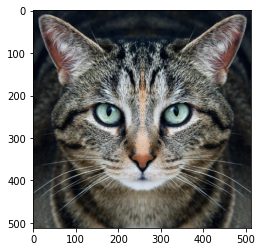

In [ ]:
# 목표 이미지(target image) 불러오기
img_path = './code_practices/images/cat.jpg'
target_image = image_loader(img_path, (512, 512))
imshow(target_image)

[ Start ]


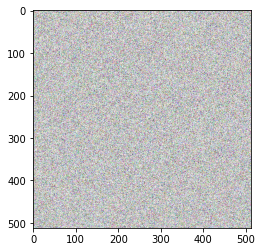

[ Step: 10 ]
Loss : 0.15869183838367462


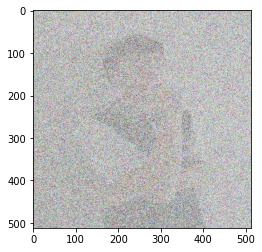

[ Step: 20 ]
Loss : 0.10796526074409485


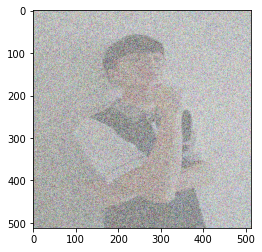

[ Step: 30 ]
Loss : 0.07345367223024368


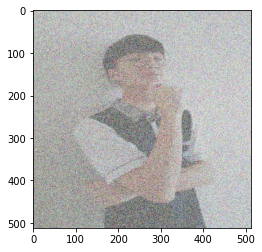

[ Step: 40 ]
Loss : 0.04997387155890465


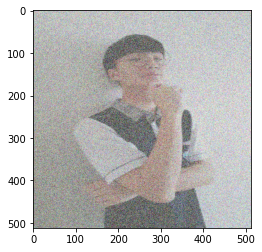

[ Step: 50 ]
Loss : 0.0339994952082634


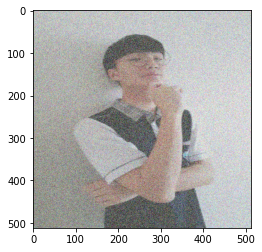

[ Step: 60 ]
Loss : 0.02313140034675598


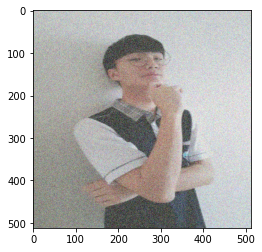

[ Step: 70 ]
Loss : 0.015737343579530716


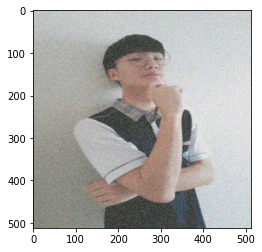

[ Step: 80 ]
Loss : 0.010706828907132149


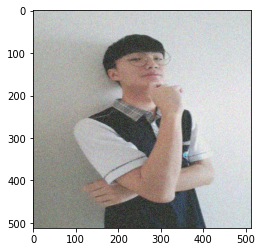

[ Step: 90 ]
Loss : 0.007284342311322689


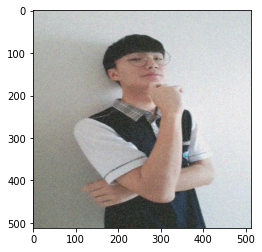

[ Step: 100 ]
Loss : 0.004955868702381849


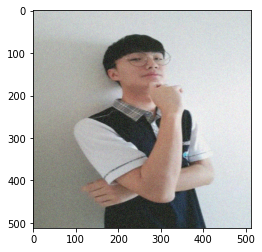

In [ ]:
loss = nn.MSELoss() # 손실함수는 MSE
iters = 100 # 반복을 100번
lr = 1e4

print("[ Start ]")
imshow(noise)

for i in range(iters):
  # required_grad 속성 값을 true로 설정하여 torch.Tensor의 연산을 추적(미분하기 위함)
  noise.requires_grad = True

  # 손실함수에 대하여 미분하여 기울기 계산
  output = loss(noise, target_image)
  output.backward()

  # 계산된 기울기를 이용하여 손실 함수가 감소하는 방향으로 업데이트
  grad = lr * noise.grad

  # 결과적으로 노이즈의 각 픽셀값이 [-eps, eps] 사이의 값이 되도록 자르기
  noise = torch.clamp(noise-grad, min = 0, max = 1).detach_() # 연산이 추적하는 것을 중단하기 위해 detach_()호출
  # torch.clamp는 noise-grad값이 min 혹은 max의 범주에 해당하도록 값을 변경하는 것이다.
  if(i + 1) % 10 == 0:
    print(f'[ Step: {i+1} ]')
    print(f'Loss : {output}')
    imshow(noise)



# 빈센트 반 고흐의 그림 불러오기

[ Content Image ]


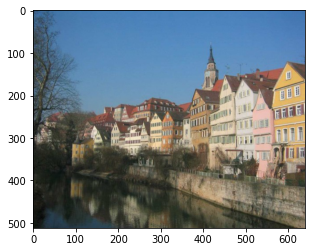

[ Style Image ]


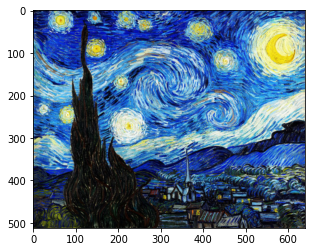

In [ ]:
# 콘텐츠(Content) 이미지와 스타일(Style) 이미지를 모두 준비합니다.
content_img = image_loader('./code_practices/images/content_img_1.jpg', (512, 640))
style_img = image_loader('./code_practices/images/style_img_1.jpg', (512, 640))

print("[ Content Image ]")
imshow(content_img)
print("[ Style Image ]")
imshow(style_img)

# 사전 학습된 VGG 네트워크 사용

In [ ]:
# 뉴럴 네트워크 모델 불러오기
cnn = models.vgg19(pretrained=True).features.to(device).eval() 
print(cnn)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPo

In [ ]:
# 입력 정규화(Normalization)를 위한 초기화
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().view(-1, 1, 1)
        self.std = std.clone().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

# Style Reconstruction 실습

* 임의의 노이즈가 특정한 이미지의 스타일을 가지도록 변환한다.
* style_layers 리스트 변수의 값을 조절하여 어떤 레이어를 이용할지 설정한다.

In [ ]:
def gram_matrix(input):
    # a는 배치 크기, b는 특징 맵의 개수, (c, d)는 특징 맵의 차원을 의미
    a, b, c, d = input.size()
    # 논문에서는 i = 특징 맵의 개수, j = 각 위치(position)
    features = input.view(a * b, c * d)
    # 행렬 곱으로 한 번에 Gram 내적 계산 가능
    G = torch.mm(features, features.t())
    # Normalize 목적으로 값 나누기
    return G.div(a * b * c * d)


# 스타일 손실(style loss) 계산을 위한 클래스 정의
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# 스타일 손실(style loss)을 계산하는 함수
def get_style_losses(cnn, style_img, noise_image):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    style_losses = []
    
    # 가장 먼저 입력 이미지가 입력 정규화(input normalization)를 수행하도록
    model = nn.Sequential(normalization)

    # 현재 CNN 모델에 포함되어 있는 모든 레이어를 확인하며
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        # 설정한 style layer까지의 결과를 이용해 style loss를 계산
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # 마지막 style loss 이후의 레이어는 사용하지 않도록
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, style_losses

In [ ]:
def style_reconstruction(cnn, style_img, input_img, iters):
    model, style_losses = get_style_losses(cnn, style_img, input_img)
    optimizer = optim.LBFGS([input_img.requires_grad_()])

    print("[ Start ]")
    imshow(input_img)

    # 하나의 값만 이용하기 위해 배열 형태로 사용
    run = [0]
    while run[0] <= iters:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0

            for sl in style_losses:
                style_score += sl.loss

            style_score *= 1e6
            style_score.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"[ Step: {run[0]} / Style loss: {style_score.item()}]")
                imshow(input_img)
            
            return style_score
        
        optimizer.step(closure)

    # 결과적으로 이미지의 각 픽셀의 값이 [0, 1] 사이의 값이 되도록 자르기
    input_img.data.clamp_(0, 1)

    return input_img

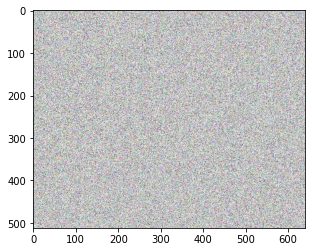

In [ ]:
# 콘텐츠 이미지와 동일한 크기의 노이즈 이미지 준비하기
input_img = torch.empty_like(content_img).uniform_(0, 1).to(device)
imshow(input_img)

[ Start ]


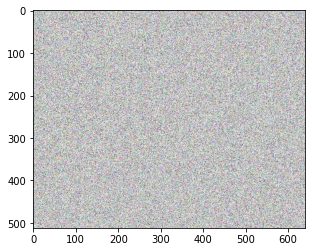

RuntimeError: ignored

In [ ]:
# style reconstruction 수행

output = style_reconstruction(cnn, style_img=style_img, input_img=input_img, iters=300)
